1. Load the data:

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Load data
Y = pd.read_excel("/Users/xieweixun/Desktop/Return.xlsx")
Y['Date'] = pd.to_datetime(Y['Date'])
Y.set_index('Date', inplace=True)
Y.columns = Y.columns.str.strip()

print(Y.head())

               Aier    Berry      BGI    Zhifei   Sanjiu   E-Jiao  Hengrui  \
Date                                                                         
2018-10-18 -6.3819% -3.6312% -0.7249% -10.5305% -1.2349% -2.3946% -4.7429%   
2018-10-19  4.5997%  0.7739%  5.4997%   6.6385%  0.8706%  1.9703%  2.0821%   
2018-10-22  7.8735%  6.4192%  3.4610%   3.6153%  4.2864%  4.8576%  7.8260%   
2018-10-23 -5.7973% -7.4731% -5.1874%  -1.8811% -4.2408% -2.9254% -1.4215%   
2018-10-24 -1.8766%  3.9712%  8.1458%  -7.2629%  1.0884% -2.1074% -3.0034%   

              Fosun  Mindray  Vcanbio   AppTec   Yiling  Pientzehuang  
Date                                                                   
2018-10-18 -2.3633%  4.6385% -5.0726% -4.4217% -2.4668%      -2.8828%  
2018-10-19  5.0226%  9.5344%  3.2811%  5.7158%  2.6616%       2.3371%  
2018-10-22  5.1486%  9.5341%  5.3421%  7.7015%  4.6564%       5.2575%  
2018-10-23 -3.3798% -3.4049% -1.9778% -0.4277% -3.0163%      -5.5010%  
2018-10-24 -1.4892%  

2. Estimating Mean Variance Portfolios

2.1. Calculating the portfolio that maximizes Sharpe ratio.

In [2]:
import riskfolio as rp
print("Riskfolio imported successfully under Rosetta x86_64")
print(rp.__version__)



Riskfolio imported successfully under Rosetta x86_64
7.0.0


In [3]:
# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,Aier,Berry,BGI,Zhifei,Sanjiu,E-Jiao,Hengrui,Fosun,Mindray,Vcanbio,AppTec,Yiling,Pientzehuang
weights,1.8685%,0.0000%,0.0000%,0.0000%,15.6192%,0.0000%,0.0000%,0.0000%,42.9934%,0.0000%,0.0000%,0.0000%,39.5189%


2.2 Plotting portfolio composition

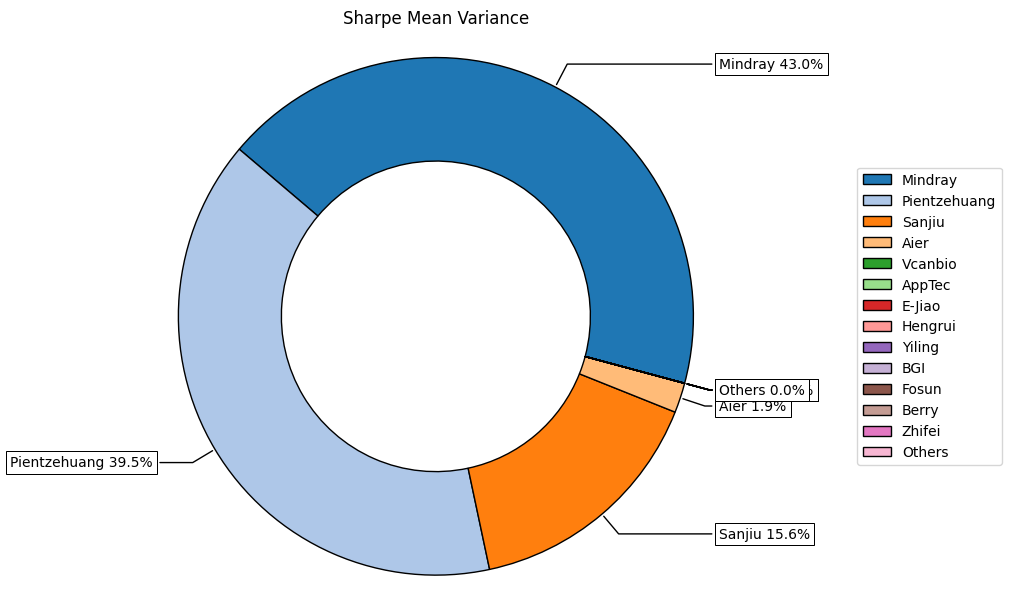

In [4]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

2.3 Plotting Risk Composition

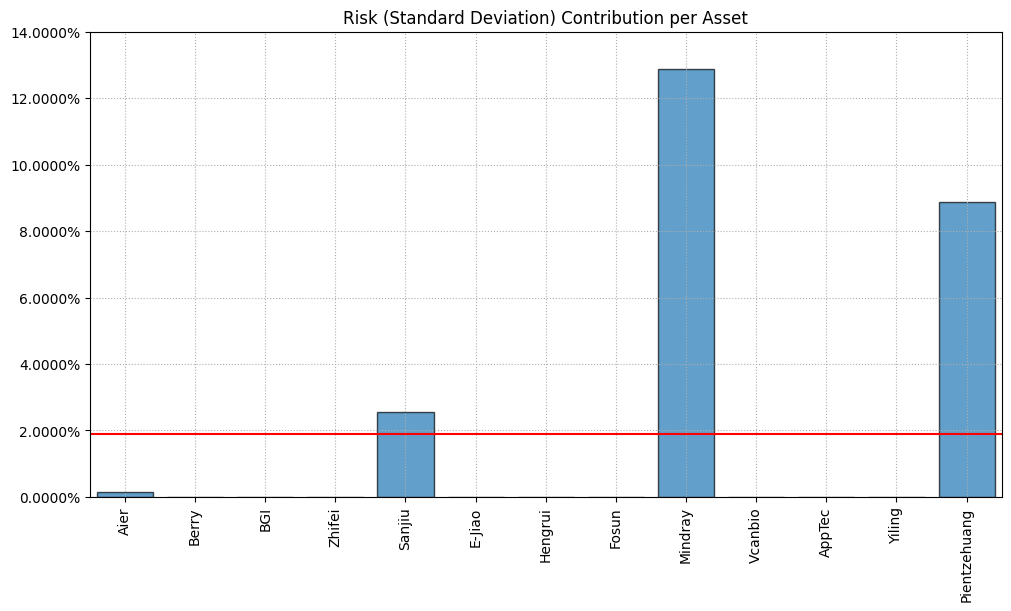

In [5]:
# Plotting the risk composition of the portfolio

ax = rp.plot_risk_con(w, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=None)

3. Estimating Risk Parity Portfolios for Other Risk Measures

3.1 Calculating the risk parity portfolio for variance.

In [6]:
b = None # Risk contribution constraints vector

w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

display(w_rp.T)

,Aier,Berry,BGI,Zhifei,Sanjiu,E-Jiao,Hengrui,Fosun,Mindray,Vcanbio,AppTec,Yiling,Pientzehuang
weights,6.3991%,9.4398%,6.4848%,5.7160%,8.5471%,9.4096%,8.9538%,7.0235%,7.9187%,7.8962%,7.1360%,6.5442%,8.5311%


3.2 Plotting portfolio composition

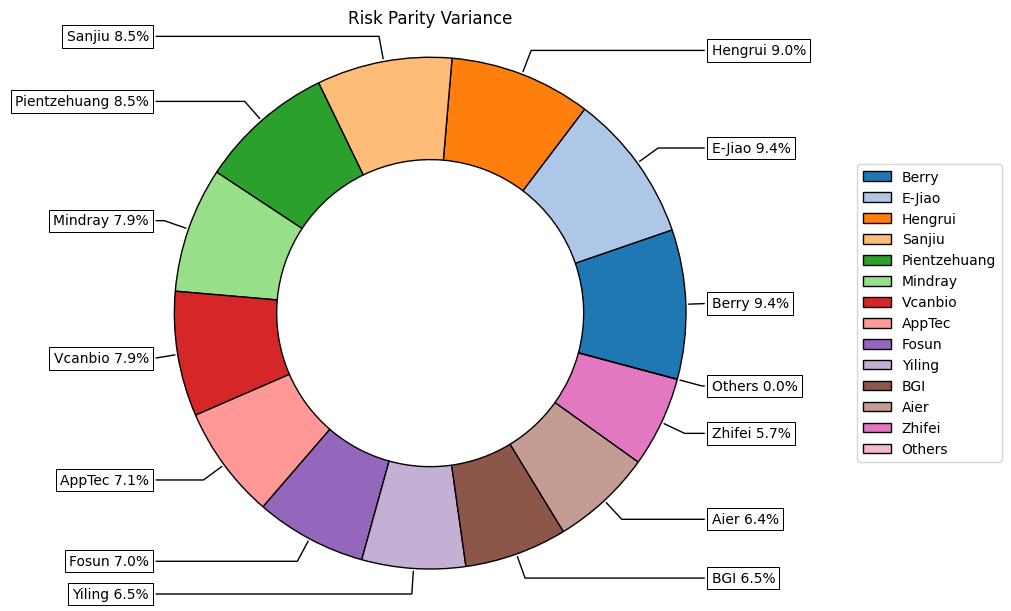

In [7]:
ax = rp.plot_pie(w=w_rp, title='Risk Parity Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)


3.3 Plotting Risk Composition

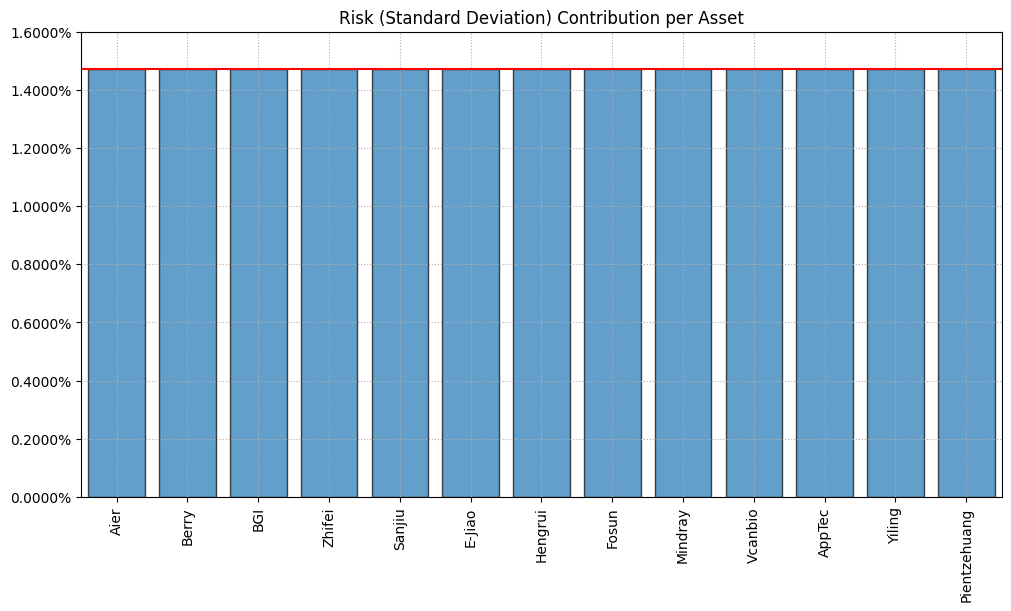

In [8]:
ax = rp.plot_risk_con(w_rp, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=None)

3.4 Calculate Optimal Portfolios for Several Risk Measures

In [9]:
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).


rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'CDaR', 'UCI', 'EDaR']
w_s = pd.DataFrame([])
success_rms = []

port.lowerret = 0
port.upperret = 1

for i in rms:
    try:
        w = port.optimization(
            model='Classic',
            rm=i,
            obj='Sharpe',
            rf=0,
            l=0,
            hist=True
        )
        w_s = pd.concat([w_s, w], axis=1)
        success_rms.append(i)
    except Exception as e:
        print(f"{i} failed: {e}")

w_s.columns = success_rms
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')


,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,CDaR,UCI,EDaR
Aier,1.87%,2.36%,0.75%,2.26%,0.72%,0.00%,1.50%,0.00%,0.00%,0.00%
Berry,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
BGI,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Zhifei,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Sanjiu,15.62%,11.55%,16.54%,12.16%,16.66%,22.09%,22.59%,42.08%,40.99%,44.65%
E-Jiao,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,3.36%,9.14%,13.45%,7.96%
Hengrui,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Fosun,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Mindray,42.99%,45.23%,43.85%,45.46%,43.79%,43.30%,31.19%,47.02%,45.56%,45.37%
Vcanbio,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,1.77%,0.00%,2.02%


<Axes: >

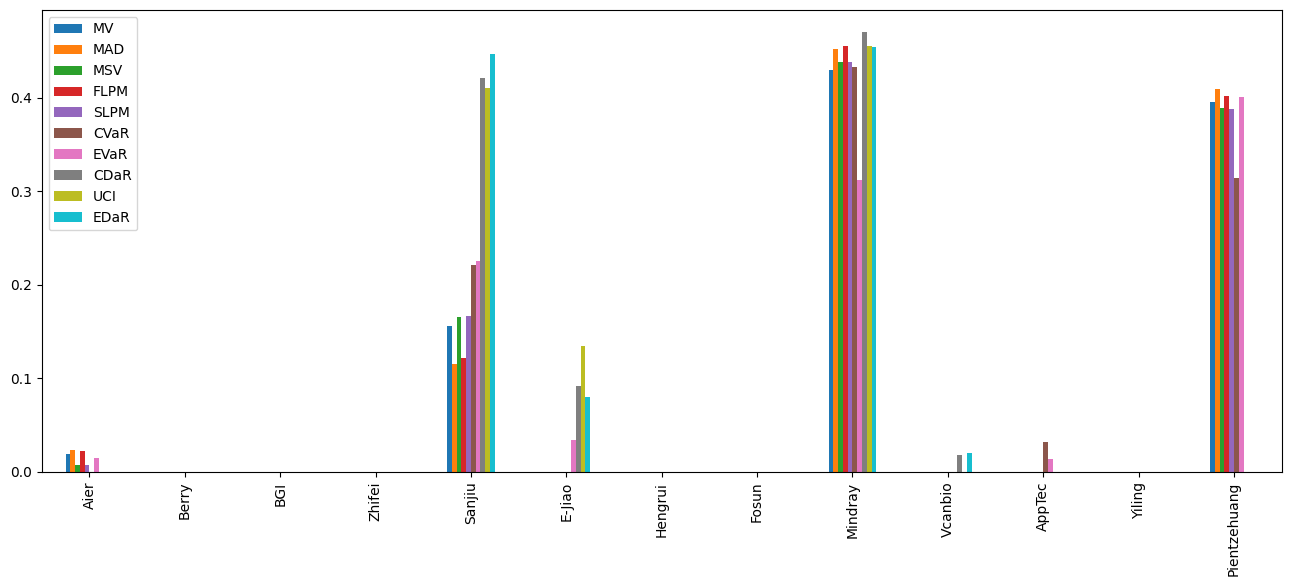

In [10]:
import matplotlib.pyplot as plt

# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(16)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)

In [11]:
# Define end date as the latest available date
end_date = Y.index[-1]

# Define start date as 5 years before the end date
start_date = end_date - pd.DateOffset(years=5)

# Extract the 5-year data range
returns_5yr = Y.loc[start_date:end_date]

# Calculate cumulative return using the formula:
# R = (∏ (1 + r_i)) - 1
five_year_return = (1 + returns_5yr).prod() - 1

# Display the result in percentage format
print("5-Year Return for each asset:")
print(five_year_return.apply(lambda x: f"{x:.2%}"))


5-Year Return for each asset:
Aier            -56.82%
Berry           -84.08%
BGI             -48.11%
Zhifei          -79.94%
Sanjiu          -15.27%
E-Jiao           28.91%
Hengrui         -40.36%
Fosun           -40.32%
Mindray         -23.81%
Vcanbio         -21.97%
AppTec          -43.82%
Yiling          -53.09%
Pientzehuang     16.82%
dtype: object


In [12]:
# Define start date as 2 year before the end date
start_date_2yr = end_date - pd.DateOffset(years=2)

# Extract the 2-year data range
returns_2yr = Y.loc[start_date_2yr:end_date]

# Calculate cumulative 1-year return using the same formula:
# R = (∏ (1 + r_i)) - 1
two_year_return = (1 + returns_2yr).prod() - 1

# Display the result in percentage format
print("\n2-Year Return for each asset:")
print(two_year_return.apply(lambda x: f"{x:.2%}"))


2-Year Return for each asset:
Aier            -51.28%
Berry           -31.53%
BGI              -3.77%
Zhifei          -64.67%
Sanjiu           -6.41%
E-Jiao           14.33%
Hengrui          -1.34%
Fosun           -29.33%
Mindray         -26.26%
Vcanbio           3.71%
AppTec          -37.86%
Yiling          -60.81%
Pientzehuang    -40.67%
dtype: object
